
This jupyter notebook may be used to test out various filters & techniques for preprocessing images.
This is the basis for all the functions defined in the filters.py file

Resource used for some of the code: https://medium.com/@VK_Venkatkumar/background-removal-general-pixel-wise-vs-deep-learning-approach-4f919fe3dd3a

In [3]:
# import the necessary modules

import cv2
import numpy as np
from IPython.display import display, Image
import seam_carving
import time

def show_img(img, width=None):
	cv2.imwrite("to_show.jpg",img)
	if width != None:
		return Image(filename="to_show.jpg", width=width)
	return Image(filename="to_show.jpg")


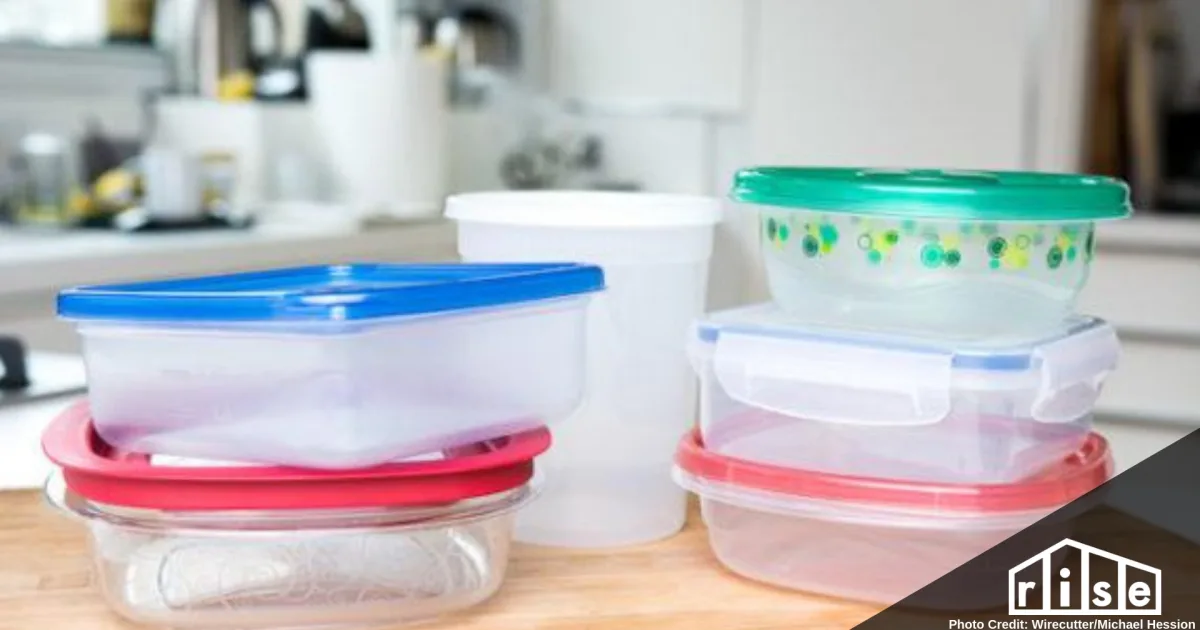

In [4]:
img_path = r"../cleaned-data/plastic containers/plastic_containers 511.jpg"
myimage =cv2.imread(img_path)
original_image =cv2.imread(img_path)
Image(filename=img_path, width=300)

Here's some code for using seam carving to resize the image
(Please note, this was just to test it out, and will likely not be used in actual preprocessing
since it distorts some images)

In [5]:
def resize_image_seam_carving(src):
	(h, w) = src.shape[:2]
	if w > h:
		target_width = 300
		aspect_ratio = w / h
		target_height = int(target_width / aspect_ratio)
	else:
		target_height = 300
		aspect_ratio = h / w
		target_width = int(target_height / aspect_ratio)
	src = cv2.resize(src, (target_width, target_height))
	start_time = time.time()
	src_h, src_w, _ = src.shape
	order = "width-first"
	
	dst = seam_carving.resize(
		src, (255, 255),
		energy_mode='backward',   # Choose from {backward, forward}
		order=order,  # Choose from {width-first, height-first}
		keep_mask=None
	)
	end_time = time.time()
	print(end_time-start_time)
	# output = Image.fromarray(dst)
	cv2.imwrite("output.png",dst)

# resize_image_seam_carving(img_path)
# Image(filename="output.png", width=300)


In [6]:
# https://stackoverflow.com/questions/43391205/add-padding-to-images-to-get-them-into-the-same-shape

# resizes to a size that can be padded later to become 255x255
def resize_to_correct_size(src, target_width=255, target_height=255):
	h, w, channels = src.shape
	if w > h:
		aspect_ratio = w / h
		img_target_height = int(target_width / aspect_ratio)
		img_target_width = target_width
	else:
		aspect_ratio = h / w
		img_target_width = int(target_height / aspect_ratio)
		img_target_height = target_height
	src = cv2.resize(src, (img_target_width, img_target_height))
	return src

In [7]:
def regular_padding(src, target_width=255, target_height=255):
	h, w, channels = src.shape
	# if width > height: resize width to 255 and scale height accordingly
	# if height > width: resize height to 255 and scale width accordingly

	if w > h:
		aspect_ratio = w / h
		img_target_height = int(target_width / aspect_ratio)
		img_target_width = target_width
	else:
		aspect_ratio = h / w
		img_target_width = int(target_height / aspect_ratio)
		img_target_height = target_height
	
	src = cv2.resize(src, (img_target_width, img_target_height))
	# print(src.shape)

	y_center = (target_height - img_target_height) // 2
	x_center = (target_width - img_target_width) // 2

	color = (0,0,0)
	result = np.full((target_height,target_width, channels), color, dtype=np.uint8)

	# # copy img image into center of result image
	# print(y_center + target_height)
	result[y_center:y_center + img_target_height, x_center:x_center + img_target_width] = src

	return result


# myimage = resize_to_correct_size(myimage, 255, 255)
# print(myimage.shape)
# show_img(myimage)
# Image(filename="output.png", width=300)

In [8]:
def gaussianBlur(myimage, radius=5):
	return cv2.GaussianBlur(myimage,(radius,radius), 0)

In [9]:

def dim_img(img, scale_factor=0.5):
	# Convert the image to a float32 type to avoid clipping issues
	image_float = img.astype(np.float32)

	# Scale the pixel values
	image_dimmed = image_float * scale_factor

	# Clip values to stay within the valid range [0, 255]
	image_dimmed = np.clip(image_dimmed, 0, 255)

	# Convert back to uint8 type
	image_dimmed = image_dimmed.astype(np.uint8)
	return image_dimmed

In [11]:

def find_laplacian_white_bg(img, ksize=5):
	# second derivative of the image intensity
	laplacian = cv2.Laplacian(img,cv2.CV_64F, ksize=ksize) 
	show_img(laplacian)
	laplacian = cv2.imread("to_show.jpg")
	laplacian = cv2.bitwise_not(laplacian)
	return laplacian

Let's try binning the pixels to reduce noise, making the important features more prominent.
(this also reduces the image size, leading to faster processing times)

In [41]:
def binning(img, num_bins=5):
	# We bin the pixels. Result will be a value 1..5
	bins = np.linspace(0, 255, num_bins+1)
	# print(bins)
	bins=np.array(bins)
	img[:,:,:] = np.digitize(img[:,:,:],bins,right=True)*51
	return img

In [13]:
def overlay(laplacian, myimage):
	# make sure laplacian has the same resolution as image_dimmed
	# print(laplacian.shape)
	# laplacian = resize_to_correct_size(laplacian, 255, 255)
	# print(laplacian.shape)

	# Create a mask where the pixels of the first image are darker
	gray1 = cv2.cvtColor(laplacian, cv2.COLOR_BGR2GRAY)
	gray2 = cv2.cvtColor(myimage, cv2.COLOR_BGR2GRAY)

	show_img(gray2)

	# Create a mask where the pixels of the first image are darker
	mask = gray1 < gray2
	# Create a 3-channel mask by stacking the single channel mask
	mask_3channel = np.stack([mask] * 3, axis=-1)

	# Overlay a % of the darker pixels from image1 onto image2
	result = np.where(mask_3channel, laplacian, (myimage*0.3+laplacian*0.6))
	return result

Load image

(133, 255, 3)


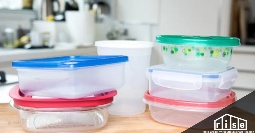

In [14]:
img_path = r"../cleaned-data/plastic containers/plastic_containers 511.jpg"
myimage =cv2.imread(img_path)
original_image =cv2.imread(img_path)

# myimage = regular_padding(myimage)
# original_image = regular_padding(original_image)
myimage = resize_to_correct_size(myimage)
original_image = resize_to_correct_size(original_image)

print(original_image.shape)
show_img(myimage, width=300)

In [13]:
# binned = binning(myimage, num_bins=5)
# show_img(binned, width=300)


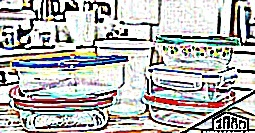

In [15]:
edges = find_laplacian_white_bg(original_image)
show_img(edges, width=400)

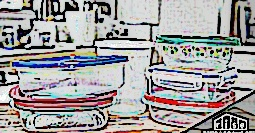

In [16]:
overlayed = overlay(edges, original_image)
show_img(overlayed, width=400)

(133, 255, 3)
316


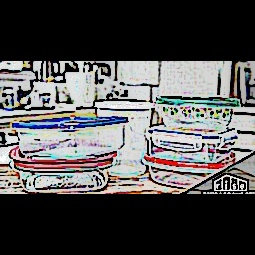

In [17]:
padded = regular_padding(overlayed)
show_img(padded)

(158, 255, 3)
303


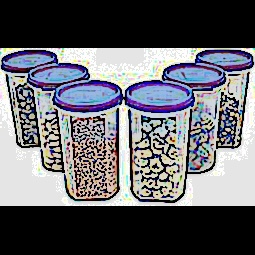

In [42]:

def preprocess(img_path):
	myimage =cv2.imread(img_path)
	return preprocess_img(myimage)


def preprocess_img(myimage):
	# myimage = regular_padding(myimage)
	# original_image = regular_padding(original_image)
	myimage = resize_to_correct_size(myimage)
	# original_image = myimage.copy()

	# print(original_image.shape)

	edges = find_laplacian_white_bg(myimage)
	# binned = binning(original_image)
	# print(binned.shape)
	overlayed = overlay(edges, myimage)
	

	padded = regular_padding(overlayed)
	return padded


img_path = r"../cleaned-data/plastic containers/plastic_containers 310.jpg"
result = preprocess(img_path)
show_img(result)

In [45]:
import cv2
from IPython.display import display, Image
from PIL import Image as PILImage
import numpy as np
from io import BytesIO


In [47]:
def cv2_to_image_bytes(img):
    is_success, buffer = cv2.imencode(".jpg", img)
    io_buf = BytesIO(buffer)
    img_pil = PILImage.open(io_buf)
    return img_pil

# Initialize webcam
cap = cv2.VideoCapture(0)

try:
    while True:
        # Capture frame-by-frame
        ret, frame = cap.read()
        if not ret:
            break

        # Apply a filter (grayscale)
        # gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        gray = preprocess_img(frame)

        # Convert to displayable image
        img_pil = cv2_to_image_bytes(gray)

        # Display the image in Jupyter
        display(img_pil)

        # Clear the output to display the next frame
        clear_output(wait=True)

        # Break the loop on key press
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break
except KeyboardInterrupt:
    pass
finally:
    # Release the capture
    cap.release()
    cv2.destroyAllWindows()

(191, 255, 3)
